In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

data = pd.read_csv('merged-file0.csv')
index = 0
data.columns.values[index] = 'comment'
comments = data['comment']

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if isinstance(text, str):
        tokens = word_tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
        return ' '.join(tokens)
    else:
        return ''

data['processed_comment'] = comments.apply(preprocess_text)

sia = SentimentIntensityAnalyzer()

def get_sentiment_label(text):
    score = sia.polarity_scores(text)['compound']
    return 1 if score >= 0 else 0

data['label'] = data['processed_comment'].apply(get_sentiment_label)

max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['processed_comment'])
sequences = tokenizer.texts_to_sequences(data['processed_comment'])
padded_sequences = pad_sequences(sequences, maxlen=max_len)

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, data['label'], test_size=0.2, random_state=42)

# Complex GRU-LSTM Hybrid Model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))

# Stacked GRU layers with return_sequences=True
model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.4))
model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.4))

# LSTM Layer
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.4))

# Additional GRU layers
model.add(GRU(64, return_sequences=True))
model.add(Dropout(0.4))
model.add(GRU(32))
model.add(Dropout(0.4))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [2]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint('GRU_LSTM_best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [checkpoint, early_stopping]
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/50
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 1657s 548ms/step - accuracy: 0.8747 - loss: 0.3196 - val_accuracy: 0.9399 - val_loss: 0.1764
Epoch 2/50
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 1697s 546ms/step - accuracy: 0.9471 - loss: 0.1624 - val_accuracy: 0.9514 - val_loss: 0.1491
Epoch 3/50
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 1617s 538ms/step - accuracy: 0.9595 - loss: 0.1330 - val_accuracy: 0.9471 - val_loss: 0.1606
Epoch 4/50
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 1653s 542ms/step - accuracy: 0.9666 - loss: 0.1111 - val_accuracy: 0.9529 - val_loss: 0.1580
Epoch 5/50
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 1633s 539ms/step - accuracy: 0.9723 - loss: 0.0945 - val_accuracy: 0.9500 - val_loss: 0.1827
Epoch 6/50
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 1663s 546ms/step - accuracy: 0.9742 - loss: 0.0847 - val_accuracy: 0.9513 - val_loss: 0.1854
Epoch 7/50
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 1628s 541ms/step - accuracy: 0.9786 - loss: 0.0736 - val_accuracy: 0.9530 - val_loss: 0.1865


In [3]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')


751/751 ━━━━━━━━━━━━━━━━━━━━ 82s 110ms/step - accuracy: 0.9525 - loss: 0.1476
Test Accuracy: 0.9513799548149109


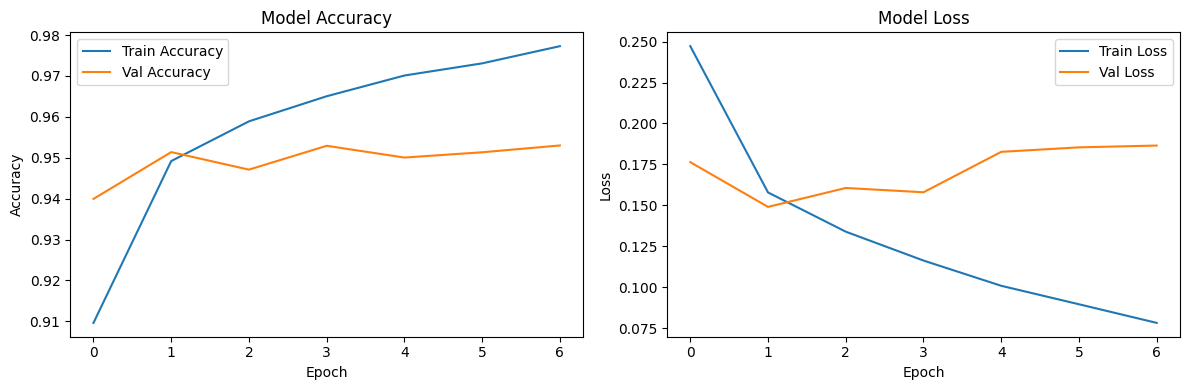

In [4]:
import matplotlib.pyplot as plt
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [5]:
# Save and download the model
import tensorflow as tf
tf.saved_model.save(model, 'GRU_LSTM')
loaded_model = tf.saved_model.load('GRU_LSTM')

In [6]:
import shutil
shutil.make_archive('GRU_LSTM', 'zip', 'GRU_LSTM')
from google.colab import files
files.download('GRU_LSTM.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

751/751 ━━━━━━━━━━━━━━━━━━━━ 81s 108ms/step


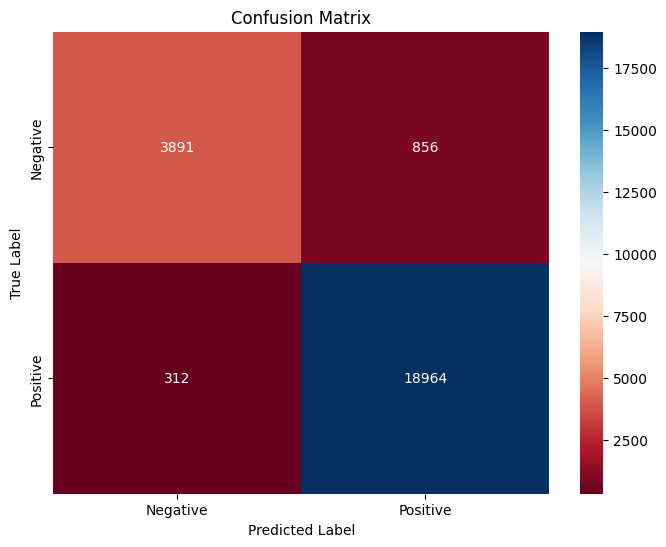

              precision    recall  f1-score   support

    Negative       0.93      0.82      0.87      4747
    Positive       0.96      0.98      0.97     19276

    accuracy                           0.95     24023
   macro avg       0.94      0.90      0.92     24023
weighted avg       0.95      0.95      0.95     24023



In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Generate predictions for the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="RdBu", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))



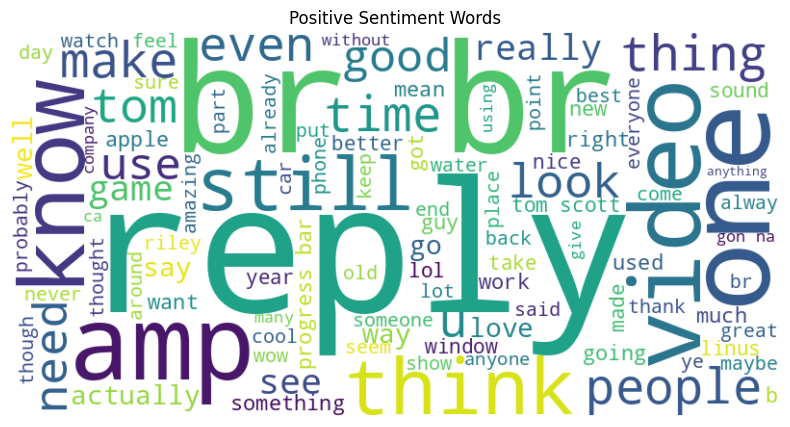

In [8]:
# Text Visualization using Word Clouds for Positive and Negative classes
def generate_word_cloud(data, label, title):
    text = ' '.join(data[data['label'] == label]['processed_comment'])
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Word cloud for positive sentiment
generate_word_cloud(data, label=1, title="Positive Sentiment Words")



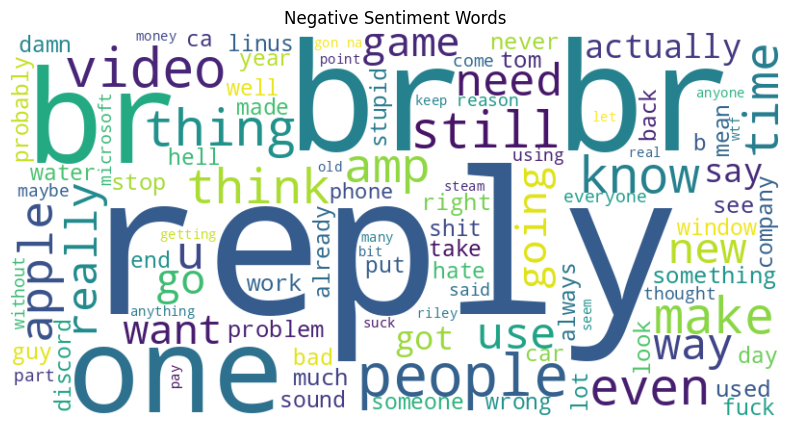

In [9]:
# Word cloud for negative sentiment
generate_word_cloud(data, label=0, title="Negative Sentiment Words")


751/751 ━━━━━━━━━━━━━━━━━━━━ 81s 108ms/step


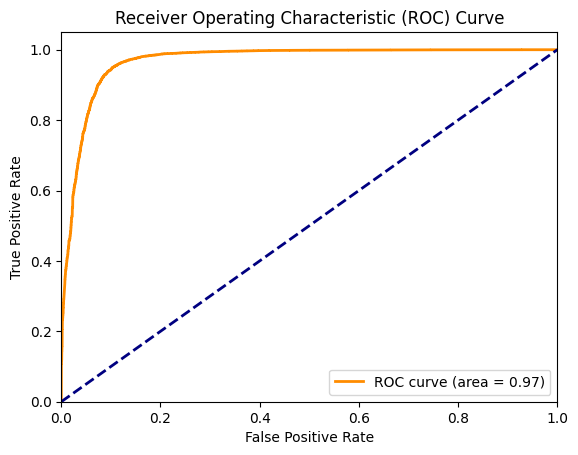

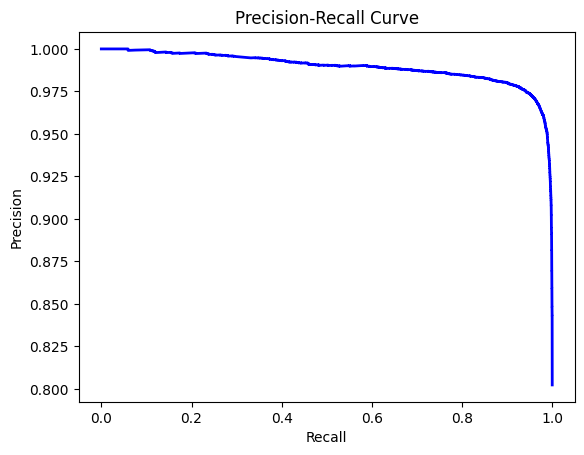

In [10]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# 1. ROC Curve
y_pred_proba = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 2. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

